<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


# Box rotation

In [ ]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt

import spm1d
from pyomeca import Analogs3d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    describe_clusters,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("data_server")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
def parse_conditions(d):
    d["hand"] = d["filename"].str[17]
    d["filename"] = d["filename"].str.replace("wu_expertsnovices[D|G]_", "")
    return d.merge(
        pd.read_csv(project_path / "_conf.csv")[["participant", "group"]].rename(
            columns={"group": "expert"}
        ),
        on="participant",
    ).assign(
        fatigue=lambda x: x["filename"].str[0].astype(int) - 1,
        height=lambda x: x["filename"].str[2].astype("category"),
        mass=lambda x: x["filename"].str[3:5].astype(int),
        filename=lambda x: x["participant"] + "_" + x["filename"],
        participant=lambda x: x["participant"].astype("category"),
        n_trial=lambda x: x["filename"].str.split("_").str[-1],
    )

In [4]:
project_path = Path(
    "/run/user/1000/gvfs/smb-share:server=10.89.24.15,share=e/Projet_ExpertsNovices/opensim"
)

In [5]:
mot = []
for file in project_path.glob("*/box_angle/*.csv"):
    mot.append(
        Analogs3d.from_csv(file, header=0, time_column=0)
        .time_normalization()
        .to_dataframe()
        .assign(filename=file.stem, participant=file.parent.parent.stem)
    )

In [159]:
data = (
    pd.concat(mot)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .pipe(parse_conditions)
    .query('fatigue == 0 & height == "r"')
    .drop("fatigue", axis=1)
)

data.sample(5)

,index,saggital_rot,frontal_rot,transverse_rot,filename,participant,hand,expert,height,mass,n_trial
17658,0.84,-51.109581,-9.657168,-13.793376,rama_1_r12_3,rama,D,0,r,12,3
1286,0.74,-42.020210,4.412481,-30.500694,romm_1_r08_2,romm,D,0,r,8,2
9433,0.40,-6.524807,22.739798,-4.033609,jead_1_r08_3,jead,D,1,r,8,3
17262,0.92,-6.798812,-4.434669,-13.421996,rama_1_r12_4,rama,D,0,r,12,4
4770,0.23,-60.259959,28.984077,4.354206,sylg_1_r12_6,sylg,D,0,r,12,6


## Exclude participants

In [160]:
blacklist = []
data = data.query("participant != @blacklist")

In [161]:
[
    data[col].unique().tolist()
    for col in ["participant", "hand", "expert", "height", "mass", "n_trial"]
]

[['antc',
  'romm',
  'char',
  'fras',
  'sylg',
  'erib',
  'gaud',
  'jono',
  'chra',
  'jead',
  'beng',
  'maxf',
  'stec',
  'davm',
  'nicl',
  'didl',
  'jull',
  'olid',
  'rama',
  'samc',
  'norl',
  'blam',
  'jeam',
  'jeaa',
  'jasb',
  'maxp'],
 ['G', 'D'],
 [0, 1],
 ['r'],
 [12, 8],
 ['5', '2', '6', '3', '4', '1']]

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [162]:
data.drop_duplicates(["filename", "participant"]).groupby(["expert", "mass"]).size()

expert  mass
0       8       77
        12      84
1       8       50
        12      39
dtype: int64

In [163]:
balanced_trials = random_balanced_design(
    data, ["expert", "mass"], random_state=RANDOM_SEED, participant=True
)
_filename, _participant = (
    balanced_trials["filename"].to_list(),
    balanced_trials["participant"].to_list(),
)

In [164]:
data = data.query("filename == @_filename & participant == @_participant")
data.drop_duplicates(["filename", "participant"]).groupby(["expert", "mass"]).size()

expert  mass
0       8       39
        12      39
1       8       39
        12      39
dtype: int64

### Stats

In [198]:
id_vars = ["filename", "participant", "expert", "height", "mass", "n_trial", "index"]
value = "frontal_rot"
stats_df = (
    data[id_vars]
    .assign(value=data[value])
    .assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
stats_df = stats_df.fillna(stats_df.mean())
stats_df

value             \
index                                                     0.00       0.01   
filename     participant expert height mass n_trial                         
antc_1_r08_1 0           0      r      8    1       -38.889003 -41.957827   
antc_1_r08_2 0           0      r      8    2       -59.889020 -62.213957   
antc_1_r08_4 0           0      r      8    4       -41.431743 -44.570397   
antc_1_r12_1 0           0      r      12   1       -58.139159 -61.357530   
antc_1_r12_3 0           0      r      12   3       -47.008640 -47.925666   
...                                                        ...        ...   
sylg_1_r08_4 25          0      r      8    4        39.957743  45.219025   
sylg_1_r08_6 25          0      r      8    6        46.087779  49.124037   
sylg_1_r12_1 25          0      r      12   1         3.232489   0.034092   
sylg_1_r12_3 25          0      r      12   3        56.911619  61.486826   
sylg_1_r12_4 25          0      r      12   4        23.665400  27.282510   

                                                                           \
index                                                     0.02       0.03   
filename     participant expert height mass n_trial                         
antc_1_r08_1 0           0      r      8    1       -45.502177 -50.910159   
antc_1_r08_2 0           0      r      8    2       -64.642565 -66.673582   
antc_1_r08_4 0           0      r      8    4       -49.264331 -52.740062   
antc_1_r12_1 0           0      r      12   1       -63.640589 -64.021177   
antc_1_r12_3 0           0      r      12   3       -48.661836 -49.397733   
...                                                        ...        ...   
sylg_1_r08_4 25          0      r      8    4        48.490464  51.279131   
sylg_1_r08_6 25          0      r      8    6        51.647857  54.416874   
sylg_1_r12_1 25          0      r      12   1         1.364248   0.748654   
sylg_1_r12_3 25          0      r      12   3        64.047649  65.625088   
sylg_1_r12_4 25          0      r      12   4        28.700805  31.128501   

                                                                           \
index                                                     0.04       0.05   
filename     participant expert height mass n_trial                         
antc_1_r08_1 0           0      r      8    1       -54.103541 -56.731130   
antc_1_r08_2 0           0      r      8    2       -67.667524 -68.000081   
antc_1_r08_4 0           0      r      8    4       -55.252697 -57.269899   
antc_1_r12_1 0           0      r      12   1       -63.802717 -63.670145   
antc_1_r12_3 0           0      r      12   3       -50.472441 -50.193162   
...                                                        ...        ...   
sylg_1_r08_4 25          0      r      8    4        53.500829  55.212201   
sylg_1_r08_6 25          0      r      8    6        56.002603  57.242294   
sylg_1_r12_1 25          0      r      12   1        -1.891474  -3.651293   
sylg_1_r12_3 25          0      r      12   3        66.976549  68.496063   
sylg_1_r12_4 25          0      r      12   4        32.383503  33.580749   

                                                                           \
index                                                     0.06       0.07   
filename     participant expert height mass n_trial                         
antc_1_r08_1 0           0      r      8    1       -58.530365 -59.192314   
antc_1_r08_2 0           0      r      8    2       -68.076087 -68.445390   
antc_1_r08_4 0           0      r      8    4       -59.329499 -61.112423   
antc_1_r12_1 0           0      r      12   1       -63.062256 -63.297837   
antc_1_r12_3 0           0      r      12   3       -49.935473 -49.770669   
...                                                        ...        ...   
sylg_1_r08_4 25          0      r      8    4        56.226507  56.516090   
sylg_1_r08_6 25          0      r      8    6     

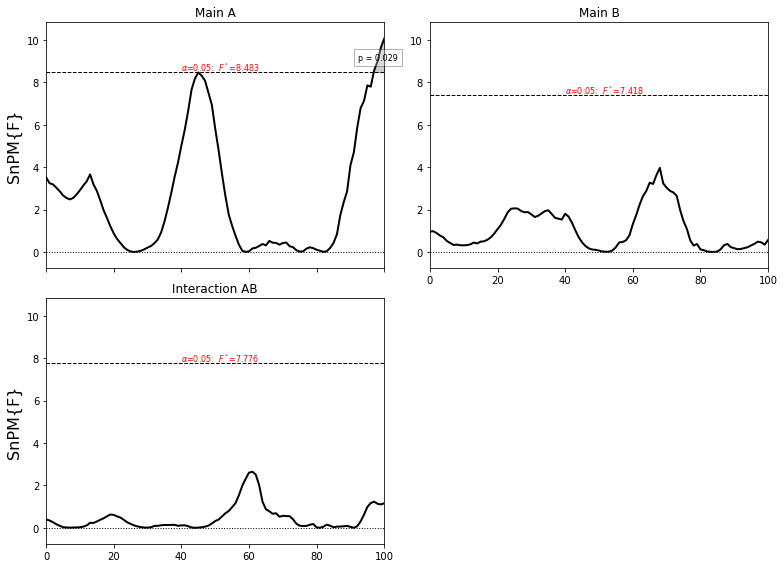

In [199]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    stats_df.to_numpy(),
    A=stats_df.index.get_level_values("expert"),
    B=stats_df.index.get_level_values("mass"),
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [200]:
for i in spmi:
    print(i)

SnPM{F} inference field
   SPM.effect         :  Main A
   SPM.z              :  (1x101) raw test stat field
   SnPM.nPermUnique   :  7.471e+275 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  8.48327
   SPM.h0reject       :  True
   SPM.p              :  (0.029)

SnPM{F} inference field
   SPM.effect         :  Main B
   SPM.z              :  (1x101) raw test stat field
   SnPM.nPermUnique   :  7.471e+275 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  7.41848
   SPM.h0reject       :  False
   SPM.p              :  ()

SnPM{F} inference field
   SPM.effect         :  Interaction AB
   SPM.z              :  (1x101) raw test stat field
   SnPM.nPermUnique   :  7.471e+275 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  7.77612
   SPM.h0reject       :  False
   SPM.p              :  ()



In [208]:
clusters = pd.DataFrame(
    {
        "effect": ["main sex", "main mass"],
        "p": [0, 0],
        "start": [0, 0],
        "end": [100, 100],
    }
)


effect = {
    "Main A": "main sex",
    "Main B": "main mass",
    "Interaction AB": "interaction sex-mass",
}
clusters = get_spm_cluster(spmi, labels=effect)
clusters

,effect,p,start,end
0,main sex,0.0293333,96.8881,100


In [209]:
base = alt.Chart(data[id_vars + [value]]).encode(
    alt.X(
        "index", title="Normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(
    alt.Y(f"mean({value})", title="box-thorax distance (% height)",)
)
sigma = base.mark_errorband(extent="stdev").encode(alt.Y(value, title=None))
men_scale = alt.Scale(scheme="set1")

In [210]:
id_vars

['filename', 'participant', 'expert', 'height', 'mass', 'n_trial', 'index']

In [211]:
alt.Chart(data[id_vars + [value]]).mark_line(opacity=0.3).encode(
    alt.X(
        "index", title="Normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    ),
    alt.Y(value),
    alt.Color("expert:N", scale=men_scale),
    alt.Detail("filename"),
    alt.Column("mass"),
    alt.Tooltip("participant"),
)

alt.Chart(...)

In [212]:
(mu + sigma)

alt.LayerChart(...)

In [213]:
(mu + sigma).encode(alt.Color("expert:N", scale=men_scale))

alt.LayerChart(...)

In [214]:
(mu + sigma).encode(alt.Color("mass:N"))

alt.LayerChart(...)

In [215]:
(mu + sigma).encode(alt.Color("expert:N", scale=men_scale)).facet(column="mass")

alt.FacetChart(...)